In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import skimage.io as skio

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import glob

In [4]:
import cv2
from FaceDetection import *
Face = FaceDetection()
def cut_image(img_path):
    faces,dim = Face.detect_faces(img_path)
    img = cv2.imread(img_path,0)
    max_index = 0
    if len(dim)>1:
        for i in range(len(dim)):
            if dim[i][2]>=dim[max_index][2]:
                max_index = i
    if len(dim) == 0:
        return 0
    else:
        new_img = img[dim[max_index][1]:dim[max_index][1]+dim[max_index][3],dim[max_index][0]:dim[max_index][0]+dim[max_index][2]]
        return new_img
        # plt.imshow(new_img,cmap="gray")

In [73]:
X = []
y = []
names = ['Ahmed','Rabea','Nasser','Dina','Abdlerhman']
for j in range(len(names)):
    folder = os.listdir(f'./Computer vision photos/{names[j]}')
    for file in folder:
        img_path = f'./Computer vision photos/{names[j]}/{file}'
        # read the image
        img = skio.imread(img_path,as_gray=True)
        # resize the image to 64x64
        img = cv2.resize(img,(64,64))
        
        if type(img) != int:

            X.append(img)
            y.append(j)
            # augment the image by flipping it horizontally
            X.append(np.fliplr(img))
            y.append(j)
            # augment the image by shifting it horizontally
            X.append(np.roll(img,10))
            y.append(j)
            # augment the image by shifting it vertically
            X.append(np.roll(img,10,axis=0))
            y.append(j)
            # augment the image by shifting it horizontally and vertically
            X.append(np.roll(np.roll(img,10,axis=0),10))
            y.append(j)
            # augment the image by rotate it alitle bit
            X.append(np.roll(np.roll(img,10,axis=0),10))
            y.append(j)
            # augment the image by rotate it alitle bit in the other direction
            X.append(np.roll(np.roll(img,-10,axis=0),-10))
            y.append(j)
            

FileNotFoundError: No such file: '/home/dina/Pictures/cv/cv_Project/data/Ahmed/IMG_20200205_033808.jpg'

In [6]:
import numpy as np

In [58]:
for i in range(len(X)):
    X[i] = cv2.resize(X[i],(64,64))

In [59]:
np.save('X',np.array(X))
np.save('y',np.array(y))

In [36]:
X_data = np.load('./X.npy')
y_data = np.load('./y.npy')

In [72]:
len(X_data)

36

In [ ]:
# augment the faces images in x_data and give them the same labels in y_data


In [60]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=0.2,shuffle=True)

In [61]:
def preprocess_data( faces_train, faces_test ):
    # flatten the imagaes from 
    X_train =  np.reshape(faces_train,(faces_train.shape[0], -1 ))
    X_test =   np.reshape(faces_test, (faces_test.shape[0], -1 ))
    mu = np.mean(X_train, axis = 0 )
    std_dev = np.mean(X_train, axis = 0)
    std_dev_mod = np.copy(std_dev)
    std_dev_mod[std_dev == 0 ] = 1
    X_train = (X_train - mu)/std_dev_mod
    # normalize the test set with same mu and std values as training set 
    X_test = (X_test - mu)/std_dev_mod
    return X_train, X_test   
    

In [62]:
X_train, X_test = preprocess_data(X_train,X_test)

In [63]:
class PCA:
    def __init__( self, optimize = False ):
        self.__optimize = optimize
        
    def __calculate_covariance_matrix( self, X ):
        if self.__optimize:
            return X @ X.T
        else:
            return X.T @ X

    def __get_eigenvecs_sorted_by_eigenvals( self, S ):
        w, v = np.linalg.eig(S)
        sorted_index = np.argsort(w)[::-1]
        eigenvals = w[sorted_index]
        eigenvecs = v[:,sorted_index]
        return eigenvals, eigenvecs

    def __get_eigenvec_for_original_matrix(  self, X, eigenvecs ):
        U = X.T @ eigenvecs
        return U
    
    def fit( self, X ):
        S = self.__calculate_covariance_matrix( X )
        eigenvals,eigenvecs =   self.__get_eigenvecs_sorted_by_eigenvals( S )
        if self.__optimize :
            B = self.__get_eigenvec_for_original_matrix(X, eigenvecs )
        else:
            B = eigenvecs
            
        self.__B = B
        self.__w = eigenvals
        return B
        
    def plot_eigenvals ( self ):
        c = np.cumsum ( self.__w )
        plt.plot( c )
        
    def get_num_components ( self, variance_threshold):
        variance_ratio = self.__w/np.sum(self.__w)
        s = 0
        i = -1
        while s < variance_threshold and s < 1.0:
            i += 1
            s +=  variance_ratio[i]
            
        return i

In [64]:
def show_images( images, num_images_to_show ):
    fig = plt.figure()
    for i in range(1,num_images_to_show+1):
        fig.add_subplot(1,num_images_to_show,i)
        img = np.reshape( images[:,i-1], (64,64) )
        plt.imshow(img, cmap='gray')

26


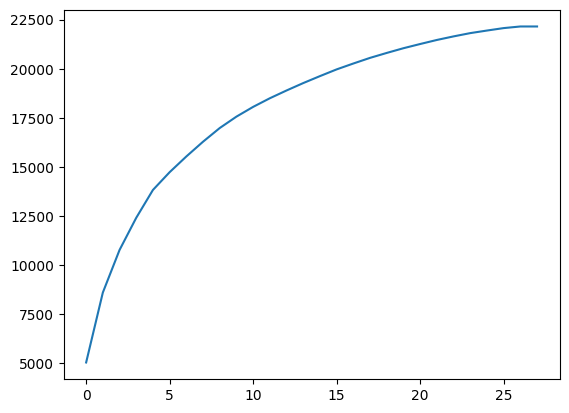

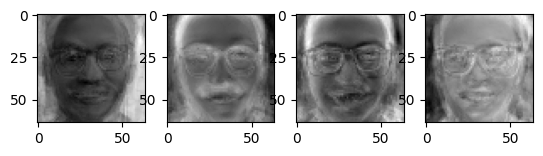

In [65]:
pca = PCA( optimize = True )
B = pca.fit(X_train)
pca.plot_eigenvals()
num_dim = pca.get_num_components(0.9999)
print( num_dim )
B = B[:,:num_dim]
# show top 4 eigenfaces
show_images( B, 4 )

In [66]:
class Projection:
    def __init__( self, B ):
        self.B = B
        
    def reduce_dim( self, X ):
        return  X @ B @ np.linalg.inv(B.T @ B)  

    def reconstruct( self, X_reduced ):
        return X_reduced @ B.T
    
    def get_projection_matrix( self ):
        P = B @ np.linalg.inv(B.T @ B) @ B.T
        return P
    
    def project( self , X ):
        P = self.get_projection_matrix()
        return X @ P

X_train_reduced.shape=(28, 26)


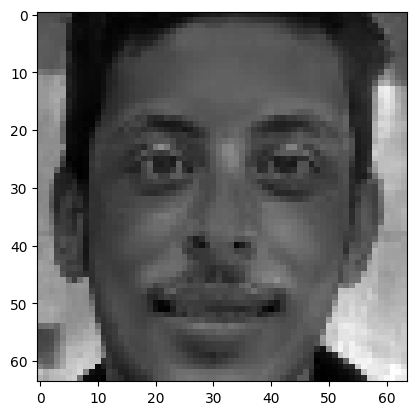

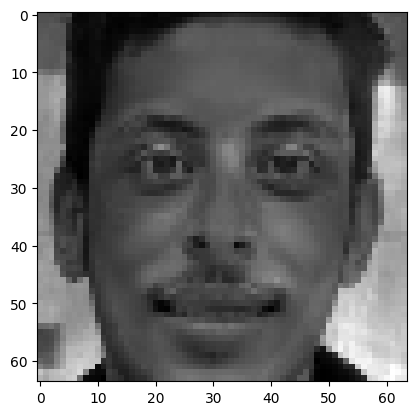

In [67]:
proj = Projection( B )
X_train_reduced = proj.reduce_dim(X_train )
print("X_train_reduced.shape="+str(X_train_reduced.shape) )
show_images(X_train.T, 1)
r_img = proj.reconstruct( X_train_reduced[0,:])
r_img = np.reshape(r_img,(4096,1))
show_images(r_img, 1)

In [68]:
X_test_reduced =proj.reduce_dim(X_test)
print("X_test_reduced.shape="+str(X_test_reduced.shape) )

X_test_reduced.shape=(8, 26)


In [69]:
class ImageClassifier:
    def __init__( self, class_count ):
        self.class_count = class_count
        
    def __get_class_mean( self, X, target ):
        class_count = self.class_count
        N,D = X.shape
        mu = np.zeros((class_count,D))
        for i in range(class_count):
            mu[i,:] = (1/N) * np.sum(X[target == i,: ], axis = 0 )
        return mu 

    def __dist(self, v1, v2 ):
        diff = v1-v2
        d = np.sqrt(np.dot(diff,diff))
        return d
                  
    def fit( self,  X, target  ):
        class_count = self.class_count
        mu = self.__get_class_mean( X, target )
        self.mu = mu
        
    def predict( self, test_img ):
        min_dist = np.inf
        min_class = -1
        for i in range( self.class_count ):
            d = self.__dist(test_img, self.mu[i,:])
            if d < min_dist:
                min_dist = d
                min_class = i
            
        return min_class, self.mu[min_class,:]

In [70]:
print("X_test_reduced.shape=" + str(X_test_reduced.shape))
print("X_train_reduced.shape=" + str(X_train_reduced.shape))
img_classifer = ImageClassifier(5)   
img_classifer.fit(X_train_reduced,y_train )
recognized_class, mu_rec = img_classifer.predict( X_test_reduced[3,: ] )
print("recognized_class="+ str(recognized_class))

X_test_reduced.shape=(8, 26)
X_train_reduced.shape=(28, 26)
recognized_class=0


In [71]:
acc = 0
pred = []
for i in range(len(y_test)):
    y_hat,mu = img_classifer.predict(X_test_reduced[i,:])
    pred.append(y_hat)
    if y_hat == y_test[i]:
        acc += 1
print(f"accuracy of model {(acc/len(y_test))*100} %")

accuracy of model 50.0 %
